## Project overview
1. [EDA](#eda)
    - [Ratings](#ratings)
    - [Tags](#tags)
    - [Movies](#movies)
    - [Merged data](#merged)
2. [Feature engineering](#fe)
3. [Merge data and check the features](#merge)
4. [Initial feature importances](#importance)
    - [Linear Regression](#linreg)
    - [Decision Tree Regressor](#tree)

In [30]:
import warnings

warnings.filterwarnings('ignore')

In [31]:
import pandas as pd
import numpy as np
np.random.seed(3104)

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

mlp.rcParams['figure.figsize'] = (10, 6)

In [33]:
ratings = pd.read_csv('ratings.csv', sep=',').head(1000000)

ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [34]:
tags = pd.read_csv('tags.csv').drop('timestamp', axis=1)

tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [35]:
movies = pd.read_csv('movies.csv')

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<a id='eda'></a>
### Exploratory data analysis 

<a id='ratings'></a>

#### Ratings

In [36]:
ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')

In [37]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

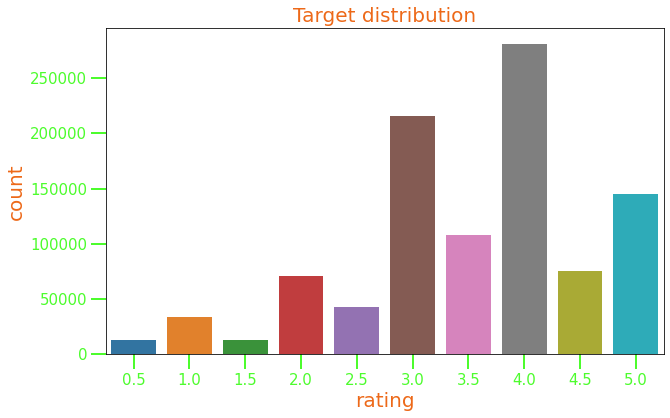

In [38]:
sns.countplot(ratings.rating)

plt.title('Target distribution')
plt.show()

<a id='tags'></a>

#### Tags

In [39]:
tags.isna().sum()

userId      0
movieId     0
tag        16
dtype: int64

In [40]:
tags[tags.tag.isna()].userId.value_counts()

116460    15
133634     1
Name: userId, dtype: int64

In [41]:
tags = tags.dropna()

<a id='movies'></a>

#### Movies

In [42]:
movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

<a id='fe'></a>

#### Feature engineering

Add mean rating for each user

In [43]:
ratings['mean_user_rating'] = ratings.userId.map(
    ratings.groupby('userId').rating.mean()
)

In [44]:
ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating
0,1,2,3.5,2005-04-02 23:53:47,3.742857
1,1,29,3.5,2005-04-02 23:31:16,3.742857
2,1,32,3.5,2005-04-02 23:33:39,3.742857
3,1,47,3.5,2005-04-02 23:32:07,3.742857
4,1,50,3.5,2005-04-02 23:29:40,3.742857


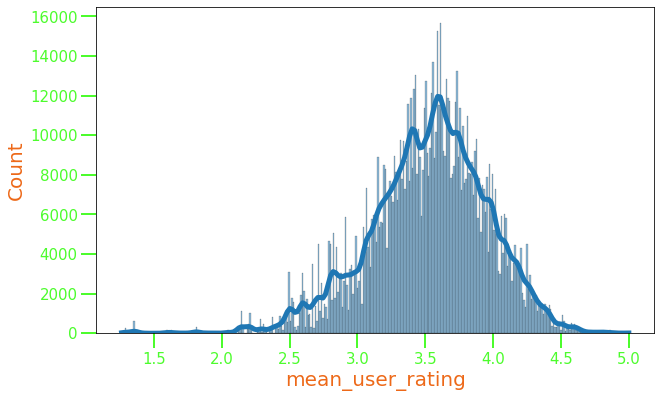

In [45]:
sns.histplot(ratings.mean_user_rating, kde=True)

plt.show()

In [46]:
ratings['year'] = ratings.timestamp.dt.year
ratings['month'] = ratings.timestamp.dt.month
ratings['weekday'] = ratings.timestamp.dt.weekday
ratings['hour'] = ratings.timestamp.dt.hour
ratings = ratings.sort_values(by='timestamp')

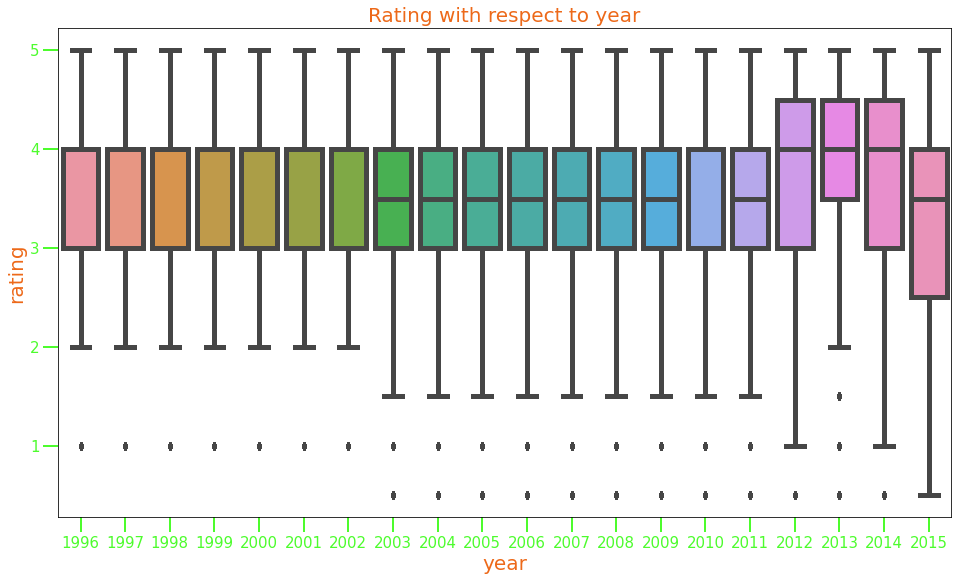

In [48]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.year, y=ratings.rating)

plt.title('Rating with respect to year')
plt.xticks()
plt.show()

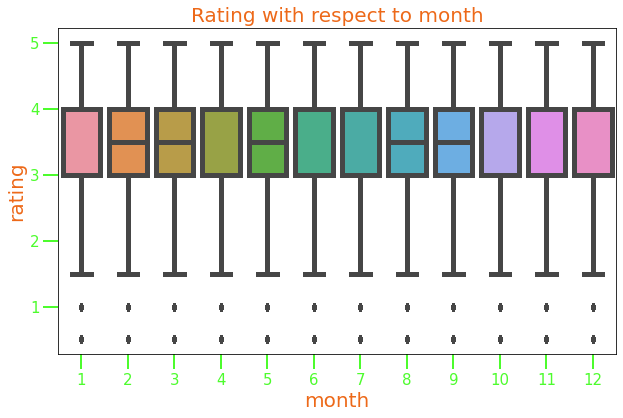

In [49]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=ratings.month, y=ratings.rating)

plt.title('Rating with respect to month')
plt.xticks()
plt.show()

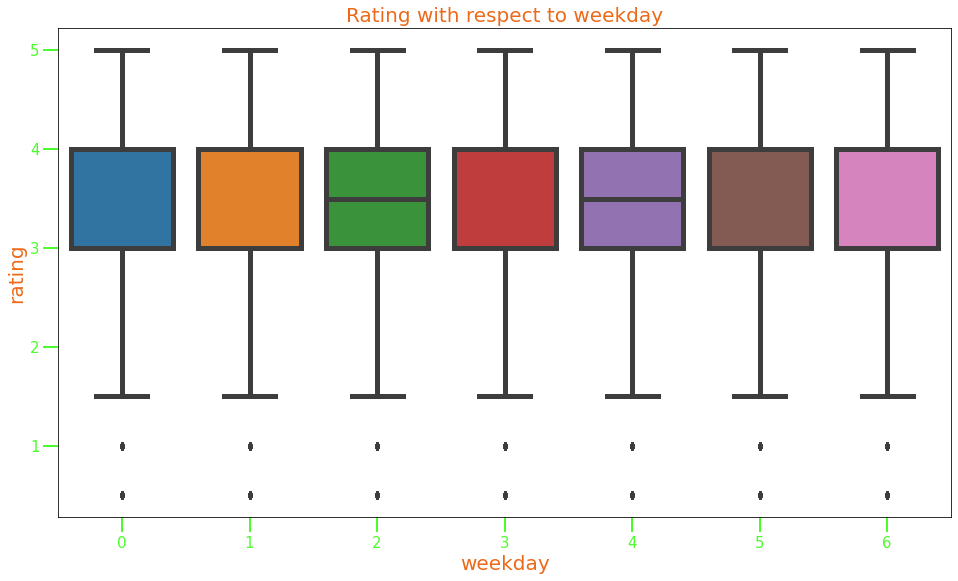

In [50]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.weekday, y=ratings.rating)

plt.title('Rating with respect to weekday')
plt.xticks()
plt.show()

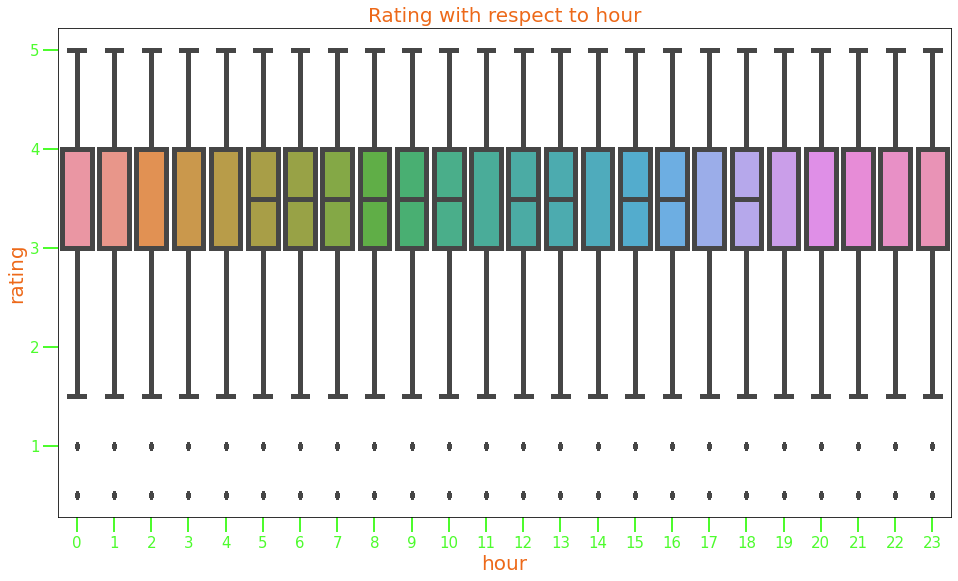

In [51]:
plt.figure(figsize=(16, 9))

sns.boxplot(x=ratings.hour, y=ratings.rating)

plt.title('Rating with respect to hour')
plt.xticks()
plt.show()

Ratings do not differ for different **month**, **weekday** and **hour**, so we will drop these columns

**Year** has some minor differences, so we may try to use it via `year_parse()`

In [52]:
def year_parse(year):
    if year < 2003:
        return 'old_rating'
    elif year <= 2011:
        return 'middle_rating'
    else:
        return 'new_rating'

In [53]:
ratings.year = ratings.year.apply(year_parse)
ratings = ratings.drop(['month', 'weekday', 'hour'], axis=1)

In [54]:
ratings.head()

,userId,movieId,rating,timestamp,mean_user_rating,year
729444,4864,79,1.0,1996-02-28 09:32:14,3.689655,old_rating
729429,4864,17,5.0,1996-02-28 09:32:14,3.689655,old_rating
729426,4864,10,3.0,1996-02-28 09:32:14,3.689655,old_rating
729427,4864,11,5.0,1996-02-28 09:32:14,3.689655,old_rating
729445,4864,92,2.0,1996-02-28 09:32:15,3.689655,old_rating


In [55]:
tags.tag.nunique()

38643

Add tag frequencies

In [56]:
tags['tag_count'] = tags.tag.map(
    tags.tag.value_counts()
)

tags.head()

,userId,movieId,tag,tag_count
0,18,4141,Mark Waters,10
1,65,208,dark hero,194
2,65,353,dark hero,194
3,65,521,noir thriller,327
4,65,592,dark hero,194


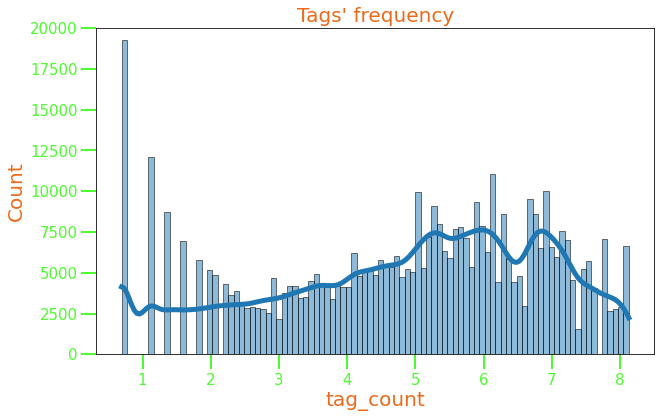

In [57]:
sns.histplot(np.log1p(tags.tag_count), kde=True)

plt.title("Tags' frequency")
plt.ylim(0, 20000)
plt.show()

In [58]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Get movie release dates

In [59]:
import re

def title_feature_extraction(title):
    m = re.search(r"\(([0-9_]+)\)", title)
    return None if m is None else m.group(1)

In [60]:
movies['movie_year'] = movies.title \
                        .apply(title_feature_extraction) \
                        .apply(lambda x: None if x is None or int(x) < 1888 else int(x))

movies.isna().sum()

movieId        0
title          0
genres         0
movie_year    25
dtype: int64

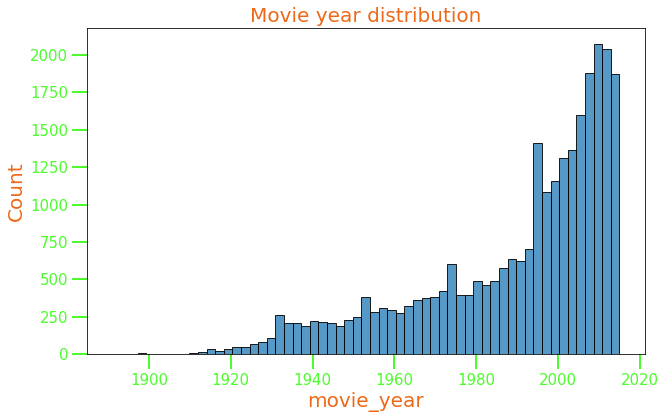

In [61]:
sns.histplot(movies.movie_year)

plt.title('Movie year distribution')
plt.show()

In [62]:
movies.movie_year = movies.movie_year.fillna(
    movies.movie_year.value_counts().index[0]
)

In [63]:
# drop_first to fix multicollinearity
genres = movies.genres.str.get_dummies(sep='|').drop('(no genres listed)', axis=1)

genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
movies = pd.concat(
    (movies, genres),
    axis=1
)

In [65]:
movies.isna().sum().sum()

0

In [66]:
movies.title = movies.title.apply(
    lambda x:
        x.split('(')[0]
)

movies.head()

,movieId,title,genres,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,Comedy,1995.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Using *TF-IDF* to extract features from the movie titles

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', stop_words='english')

df = pd.DataFrame(tf.fit_transform(movies.title).todense())
df.columns = tf.get_feature_names()

df.sample(5)

,10th,110th,11th,12th,13b,13hrs,13th,14th,19th,1st,...,école,époque,équipe,état,étoile,étudiante,öga,último,üvegtigris,貞子3d
1131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
movies['movie_tf_idf_mean'] = df.mean(axis=1)

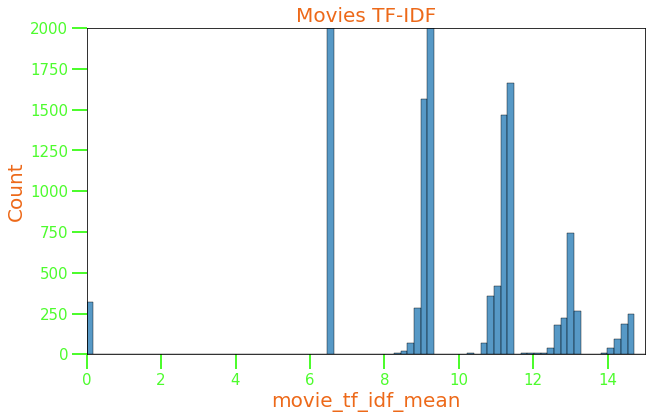

In [69]:
sns.histplot(movies.movie_tf_idf_mean * 1e5)

plt.xlim(0, 15)
plt.ylim(0, 2000)
plt.title('Movies TF-IDF')
plt.show()

In [70]:
movies = movies.drop(['title', 'genres'], axis=1)

movies.head()

,movieId,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean
0,1,1995.0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000091
1,2,1995.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000066
2,3,1995.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.000111
3,4,1995.0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0.000092
4,5,1995.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000113


<a id='merge'></a>

#### Merge data

In [71]:
ratings.head(1)

,userId,movieId,rating,timestamp,mean_user_rating,year
729444,4864,79,1.0,1996-02-28 09:32:14,3.689655,old_rating


In [72]:
tags.head(1)

,userId,movieId,tag,tag_count
0,18,4141,Mark Waters,10


In [73]:
movies.head(1)

,movieId,movie_year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean
0,1,1995.0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000091


In [74]:
df = pd.merge(
    ratings, movies, 
    on='movieId',
    how='left'
)

df.head()

,userId,movieId,rating,timestamp,mean_user_rating,year,movie_year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,old_rating,1996.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0.000066
1,4864,17,5.0,1996-02-28 09:32:14,3.689655,old_rating,1995.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.000093
2,4864,10,3.0,1996-02-28 09:32:14,3.689655,old_rating,1995.0,1,1,0,...,0,0,0,0,0,0,1,0,0,0.000066
3,4864,11,5.0,1996-02-28 09:32:14,3.689655,old_rating,1995.0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.000092
4,4864,92,2.0,1996-02-28 09:32:15,3.689655,old_rating,1996.0,0,0,0,...,1,0,0,0,0,0,1,0,0,0.000093


In [75]:
df.shape[0] == 1e6

True

In [76]:
df['view_delta'] = df.timestamp.dt.year - df.movie_year

df.head(1)

,userId,movieId,rating,timestamp,mean_user_rating,year,movie_year,Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean,view_delta
0,4864,79,1.0,1996-02-28 09:32:14,3.689655,old_rating,1996.0,0,0,0,...,0,0,0,0,0,1,0,0,0.000066,0.0


Check our generated features

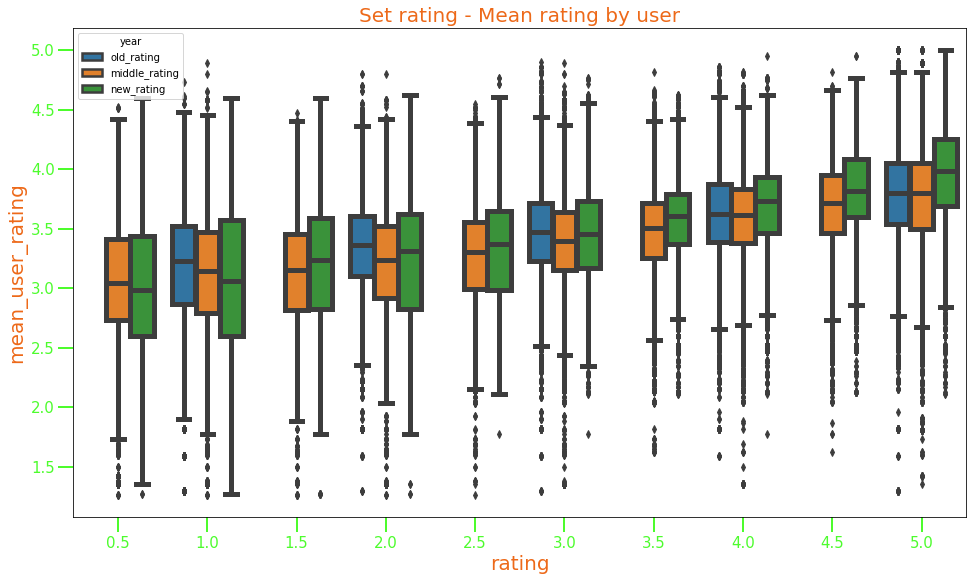

In [97]:
plt.figure(figsize=(16, 9))
sns.boxplot(x=df.rating, y=df.mean_user_rating, hue=df.year)

plt.title('Set rating - Mean rating by user')
plt.show()

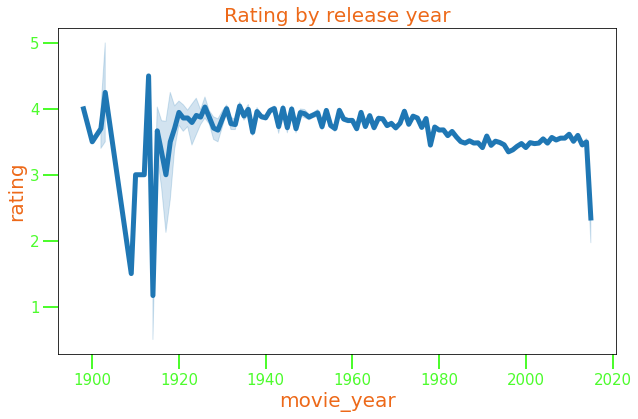

In [95]:
sns.lineplot(x=df.movie_year, y=df.rating)

plt.title('Rating by release year')
plt.show()

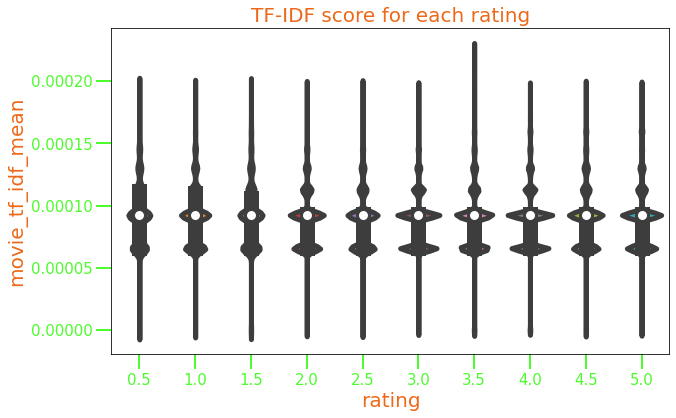

In [115]:
sns.violinplot(x=df.rating, y=df.movie_tf_idf_mean)

plt.title('TF-IDF score for each rating')
plt.show()

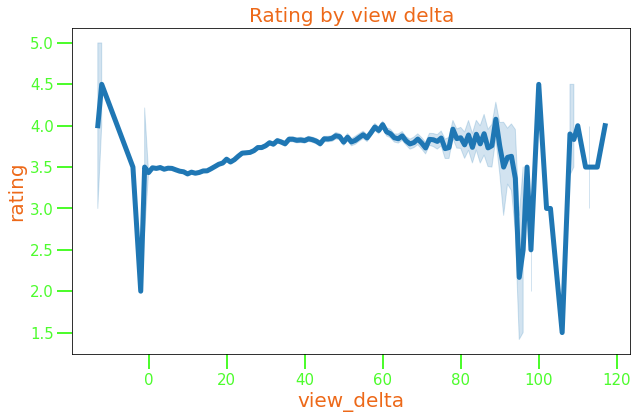

In [117]:
sns.lineplot(x=df.view_delta, y=df.rating)

plt.title('Rating by view delta')
plt.show()

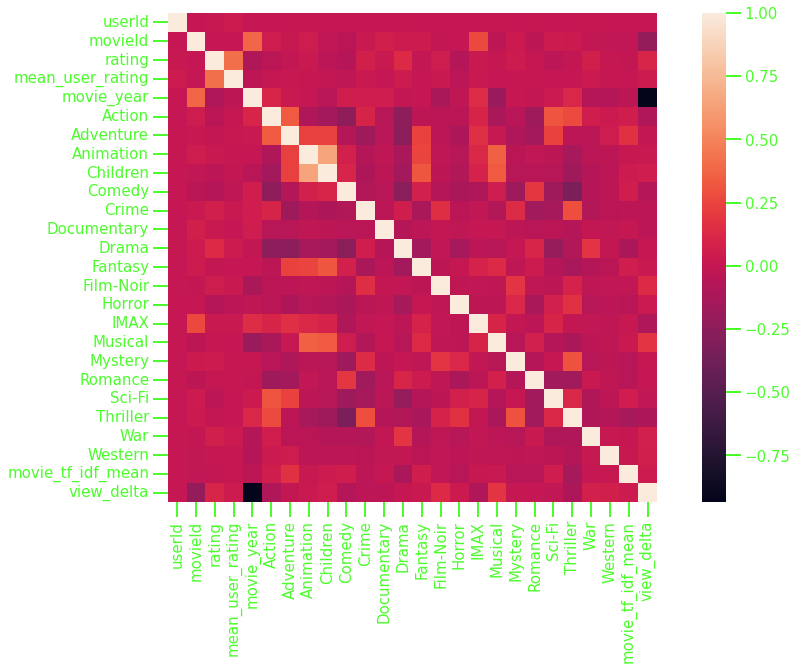

In [123]:
plt.figure(figsize=(16, 9))
sns.heatmap(df.corr(), square=True)

plt.show()

<a id='importances'></a>
### Initial feature importances

<a id='linreg'></a>
#### Linear Regression

In [132]:
df_ = df.copy().drop('timestamp', axis=1)
df_ = pd.concat(
    (df_.drop('year', axis=1), pd.get_dummies(df_.year, drop_first=True)),
    axis=1
)

df_.head()

,userId,movieId,rating,mean_user_rating,movie_year,Action,Adventure,Animation,Children,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_tf_idf_mean,view_delta,new_rating,old_rating
0,4864,79,1.0,3.689655,1996.0,0,0,0,0,0,...,0,0,0,1,0,0,0.000066,0.0,0,1
1,4864,17,5.0,3.689655,1995.0,0,0,0,0,0,...,0,1,0,0,0,0,0.000093,1.0,0,1
2,4864,10,3.0,3.689655,1995.0,1,1,0,0,0,...,0,0,0,1,0,0,0.000066,1.0,0,1
3,4864,11,5.0,3.689655,1995.0,0,0,0,0,1,...,0,1,0,0,0,0,0.000092,1.0,0,1
4,4864,92,2.0,3.689655,1996.0,0,0,0,0,0,...,0,0,0,1,0,0,0.000093,0.0,0,1


In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

X, y = df_.drop(['userId', 'movieId', 'rating'], axis=1), df_.rating
X_ = StandardScaler().fit_transform(X)

model = LinearRegression()
model.fit(X_, y)

LinearRegression()

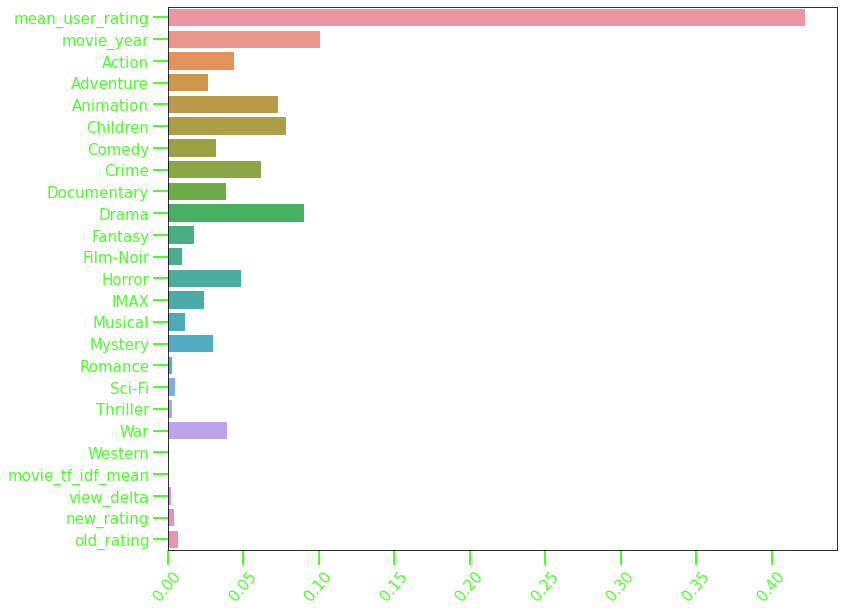

In [174]:
plt.figure(figsize=(12, 10))

sns.barplot(y=X.columns, x=abs(model.coef_))
plt.xticks(rotation=50)
plt.show()

In [150]:
model.coef_

array([-4.37917708e-04,  2.93117520e-02,  4.22827817e-01, -1.49176017e-01,
       -4.37917022e-02,  2.74983105e-02,  7.25889110e-02, -7.75541586e-02,
       -3.13612542e-02,  6.21706543e-02,  3.71654943e-02,  8.91789143e-02,
        1.71562644e-02,  8.48118803e-03, -4.84267321e-02,  1.92441858e-02,
       -1.20547722e-02,  2.94700063e-02,  3.08127665e-03, -5.14620280e-03,
       -2.44362236e-03,  3.89322769e-02, -1.34197804e-03, -1.70583436e-05,
       -4.16722811e-02,  1.70041192e-03, -1.24205866e-02])

**mean_user_rating**, **movie_year**, **Children** and **Drama** have the most importance, according to `Linear Regression` model

<a id='tree'></a>
#### Decision Tree Regressor

In [162]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()
model.fit(X_, y)

DecisionTreeRegressor()

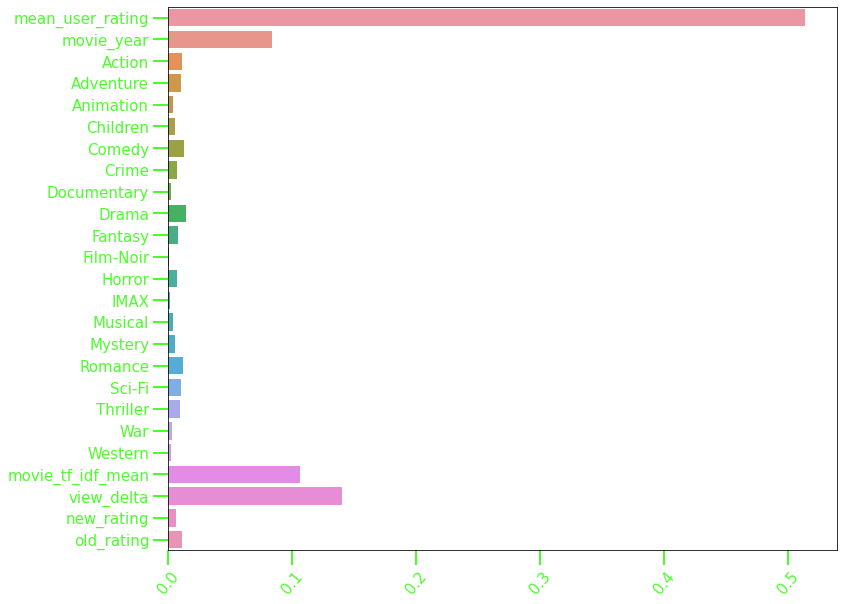

In [165]:
plt.figure(figsize=(12, 10))

sns.barplot(y=X.columns, x=model.feature_importances_)
plt.xticks(rotation=50)
plt.show()

**mean_user_rating**, **movie_year**, **movie_tf_idf_mean** and **view_delta** have the most importance, according to `Linear Regression` model, which kind of makes sense